In [1]:
import tensorflow as tf
import visual_data_explanation as vde
from gridworld import GridworldMdp
from utils import plot_trajectory, plot_reward
import numpy as np

% matplotlib inline
import matplotlib.pyplot as plt

/Users/ngundotra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [9]:
graph = tf.Graph()
export_dir = 'model_save'
sess = tf.Session(graph=graph)
tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)

INFO:tensorflow:Restoring parameters from model_save/variables/variables


meta_info_def {
  stripped_op_list {
    op {
      name: "Add"
      input_arg {
        name: "x"
        type_attr: "T"
      }
      input_arg {
        name: "y"
        type_attr: "T"
      }
      output_arg {
        name: "z"
        type_attr: "T"
      }
      attr {
        name: "T"
        type: "type"
        allowed_values {
          list {
            type: DT_BFLOAT16
            type: DT_HALF
            type: DT_FLOAT
            type: DT_DOUBLE
            type: DT_UINT8
            type: DT_INT8
            type: DT_INT16
            type: DT_INT32
            type: DT_INT64
            type: DT_COMPLEX64
            type: DT_COMPLEX128
            type: DT_STRING
          }
        }
      }
    }
    op {
      name: "AddN"
      input_arg {
        name: "inputs"
        type_attr: "T"
        number_attr: "N"
      }
      output_arg {
        name: "sum"
        type_attr: "T"
      }
      attr {
        name: "N"
        type: "int"
        has_minimum: t

In [3]:
grids = vde.grids

In [10]:
mdp = GridworldMdp(grids[2])

In [11]:
walls, reward, start = mdp.convert_to_numpy_input()

In [12]:
def repeat_vector(walls, reward, num=20):
    w = np.stack([walls] * 20)
    r = np.stack([reward] * 20)
    return w, r
w, r = repeat_vector(walls, reward)

In [13]:
for op in graph.get_operations():
    if 'v_' in op.name and 'grad' not in op.name:
        print(op)
    if "output" in op.name:
        print(op.name)

name: "v_1/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 3
    }
  }
}

name: "v_1"
op: "Max"
input: "q_1"
input: "v_1/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}

name: "v_2/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT32
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_INT32
      tensor_shape {
      }
      int_val: 3
    }
  }
}

name: "v_2"
op: "Max"
input: "q_2"
input: "v_2/reduction_indices"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "Tidx"
  value {
    type: DT_INT32
  }
}
attr {
  key: "keep_dims"
  value {
    b: true
  }
}

name: "v_3/reduction_indices"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_INT

In [14]:
# Last value maps
rvs = graph.get_operation_by_name("v_9")
rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
rvs = rvs[0][0].squeeze()
rvs.shape

(8, 8)

In [15]:
oo = graph.get_operation_by_name('output')

In [16]:
oo.outputs

[<tf.Tensor 'output:0' shape=(1280, 5) dtype=float32>]

In [20]:
values = np.max(qs, axis=-1)
values = np.reshape(values, (20, 8, 8))
val = values[0]

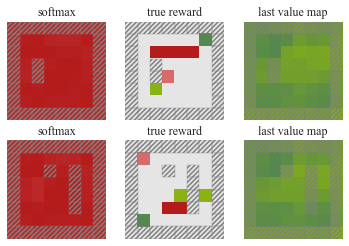

In [24]:
fig, axes = plt.subplots(2, 3)

for ax, gr in zip(axes, grids[2:4]):
    walls, reward, _ = GridworldMdp(gr).convert_to_numpy_input()
    
    # plotting softmax output of VIN (last layer)
    oo = graph.get_operation_by_name('output')
    qs = sess.run(feed_dict={'image:0': w, 'reward:0': r}, fetches=oo.outputs)[0]
    values = np.max(qs, axis=-1)
    val = np.reshape(values, (20, 8, 8))[0]
    plot_reward(val - 5.0, walls, "softmax", fig, ax[0])
    # plotting actual reward
    plot_reward(reward, walls, "true reward", fig, ax[1])
    # plotting last value map of VIN (last VIN block)
    rvs = graph.get_operation_by_name("v_9")
    rvs = sess.run(feed_dict={'image:0':w, 'reward:0': r}, fetches=rvs.outputs)
    rvs = rvs[0][0].squeeze()
    plot_reward(rvs, walls, 'last value map', fig, ax[2])
    
fig.savefig("testing_value_maps.jpg")